

# Home work 01

# Name: Zahid Hussain



## Adaptive optimizers

In this seminar you will implement a logistic regression and train it using stochastic gradient descent modiffications, numpy and your brain.

In [ ]:
#load our dakka
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Two-dimensional classification

To make things more intuitive, let's solve a 2D classification problem with syntetic data.

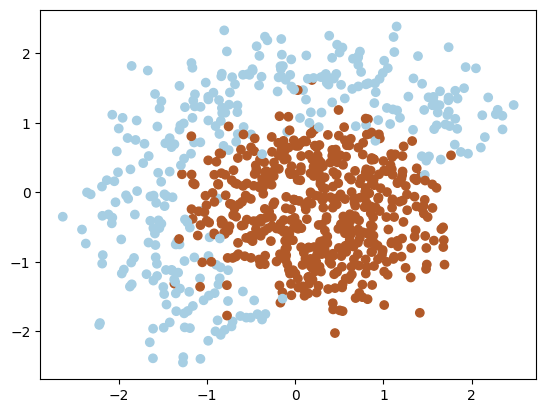

In [27]:
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]


plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [28]:
print("X:\n{}\ny:\n{}".format(X[:3],y[:3]))

X:
[[ 0.37739981  1.54899818]
 [ 0.88354907 -0.35917127]
 [-0.54112464 -0.07392033]]
y:
[0 1 1]


**Your task starts here**

Since the problem above isn't linearly separable, we add quadratic features to the classifier.

Implement this transformation in the __expand__ function __[1 point]__.

In [29]:
def expand(X):
    """
    Adds quadratic features.
    This function allows your linear model to make non-linear separation.

    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]

    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6))

    X_expanded[:, 0] = X[:, 0]              # feature0
    X_expanded[:, 1] = X[:, 1]              # feature1
    X_expanded[:, 2] = X[:, 0] ** 2         # feature0^2
    X_expanded[:, 3] = X[:, 1] ** 2         # feature1^2
    X_expanded[:, 4] = X[:, 0] * X[:, 1]    # feature0*feature1
    X_expanded[:, 5] = 1.0                  # bias term

    return X_expanded


In [30]:
#simple test on random numbers
#[all 8 random numbers are 100% random :P]
dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

#call your expand function
dummy_expanded = expand(dummy_X)

#what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

#tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape==dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")


Seems legit!


### Logistic regression (4 pts)
Now, let's write function that predicts class given X as in logistic regression.

The math should look like this:

$$ P(y| \vec x, \vec w) = \sigma(\vec x \cdot \vec w )$$

where x represents features, w are weights and $$\sigma(a) = {1 \over {1+e^{-a}}}$$

We shall omit $ \vec {arrows} $ in further formulae for simplicity.

In [31]:
def classify(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above

    __don't forget to expand X inside classify and other functions__

    :param X: feature matrix X of shape [n_samples,2] (non-exanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """
    X_expanded = expand(X)                 # expand features
    logits = np.dot(X_expanded, w)         # linear combination
    probs = 1 / (1 + np.exp(-logits))      # sigmoid
    return probs


In [32]:
#sample usage / test just as the previous one
dummy_weights = np.linspace(-1,1,6)

dummy_probs = classify(dummy_X,dummy_weights)

dummy_answers = np.array([ 0.73105858,  0.450166  ,  0.02020883,  0.59844257])

assert isinstance(dummy_probs,np.ndarray), "please return np.array"
assert dummy_probs.shape == dummy_answers.shape, "please return an 1-d vector with answers for each object"
assert np.allclose(dummy_probs,dummy_answers,1e-3), "There's something non-canonic about how probabilties are computed"

The loss you should try to minimize is the Logistic Loss aka crossentropy aka negative log-likelihood:

$$ L =  - {1 \over N} \sum_i {y_i \cdot log P(y_i|x_i,w) + (1-y_i) \cdot log (1-P(y_i|x_i,w))}$$



In [33]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector y [n_samples] of +1/0,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    probs = classify(X, w)  # predicted probabilities
    # add small epsilon for numerical stability
    eps = 1e-15
    probs = np.clip(probs, eps, 1 - eps)

    loss = -np.mean(y * np.log(probs) + (1 - y) * np.log(1 - probs))
    return loss


In [34]:
dummy_y = np.array([0,1,0,1])
dummy_loss = compute_loss(dummy_X,dummy_y,dummy_weights)

assert np.allclose(dummy_loss,0.66131), "something wrong with loss"

Since we train our model with gradient descent, we gotta compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla L = {\partial L \over \partial w} = ...$$

No, we won't be giving you the exact formula this time. Instead, try figuring out a derivative with pen and paper.

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how L changes if you shift w by $10^{-5}$ or so).

In [35]:

def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector y [n_samples] of +1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X_expanded = expand(X)                   # shape [N,6]
    probs = classify(X, w)                   # shape [N]

    grad = np.dot(X_expanded.T, (probs - y)) / X.shape[0]
    return grad


In [36]:
#tests
dummy_grads = compute_grad(dummy_X,dummy_y,dummy_weights)

#correct answers in canonic form
dummy_grads_ans = np.array([-0.06504252, -0.21728448, -0.1379879 , -0.43443953,  0.107504  , -0.05003101])

assert isinstance(dummy_grads,np.ndarray)
assert dummy_grads.shape == (6,), "must return a vector of gradients for each weight"
assert len(set(np.round(dummy_grads/dummy_grads_ans,3))), "gradients are wrong"
assert np.allclose(dummy_grads,dummy_grads_ans,1e-3), "gradients are off by a coefficient"

Here's an auxiliary function that visualizes the predictions

In [37]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.subplot(1,2,2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

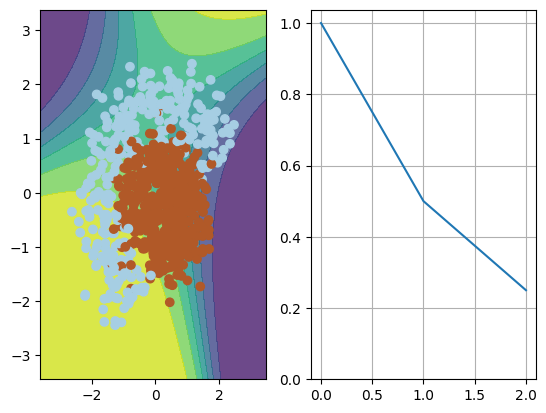

In [38]:
visualize(X,y,dummy_weights,[1,0.5,0.25],)

### Training [1 point]
In this section, we'll use the functions you wrote to train our classifier using stochastic gradient descent.

Try to find an optimal learning rate for gradient descent for the given batch size.

**Don't change the batch size!**

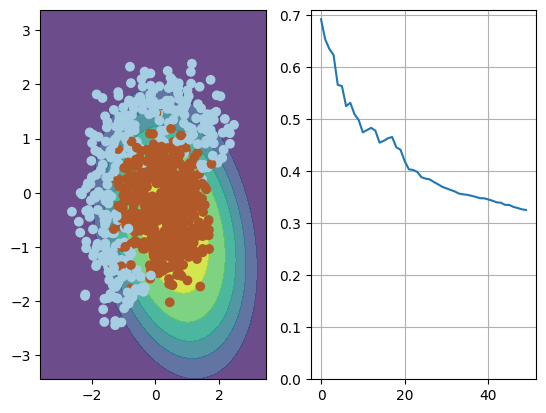

<Figure size 640x480 with 0 Axes>

In [39]:
w = np.array([0,0,0,0,0,1])   # initialize weights with bias term

alpha = 0.1

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    # SGD update
    w = w - alpha * compute_grad(X[ind,:], y[ind], w)

# Final visualization
visualize(X, y, w, loss)
plt.clf()


Implement gradient descent with momentum and test it's performance for different learning rate and momentum values. __[2 points]__

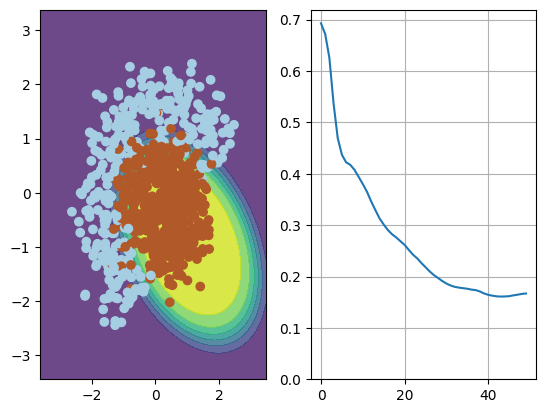

<Figure size 640x480 with 0 Axes>

In [40]:
w = np.array([0,0,0,0,0,1])

alpha = 0.1
mu    = 0.9

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)

v = np.zeros_like(w)  # initialize velocity

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    grad = compute_grad(X[ind,:], y[ind], w)

    # Momentum update
    v = mu * v - alpha * grad
    w = w + v

# Final visualization
visualize(X, y, w, loss)
plt.clf()


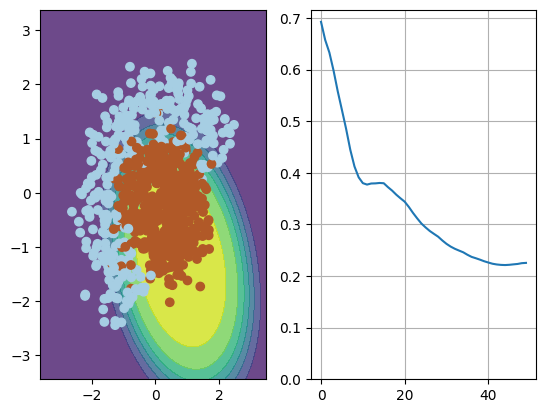

<Figure size 640x480 with 0 Axes>

In [41]:
w = np.array([0,0,0,0,0,1])

alpha = 0.05
mu    = 0.9

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)

v = np.zeros_like(w)  # initialize velocity

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    grad = compute_grad(X[ind,:], y[ind], w)

    # Momentum update
    v = mu * v - alpha * grad
    w = w + v

# Final visualization
visualize(X, y, w, loss)
plt.clf()


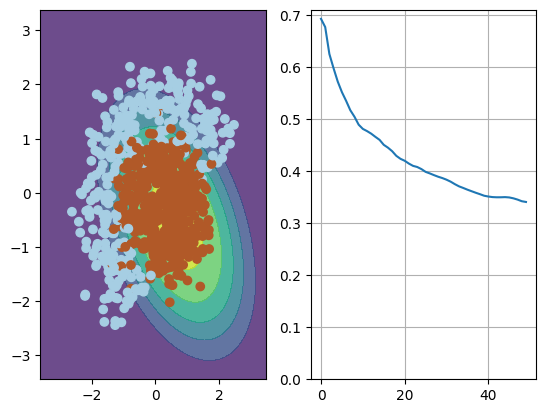

<Figure size 640x480 with 0 Axes>

In [42]:
w = np.array([0,0,0,0,0,1])

alpha = 0.05
mu    = 0.5

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)

v = np.zeros_like(w)  # initialize velocity

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    grad = compute_grad(X[ind,:], y[ind], w)

    # Momentum update
    v = mu * v - alpha * grad
    w = w + v

# Final visualization
visualize(X, y, w, loss)
plt.clf()

Implement RMSPROP algorithm __[2 points]__


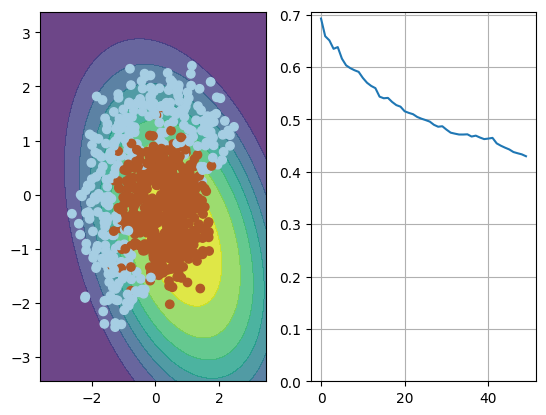

<Figure size 640x480 with 0 Axes>

In [44]:
w = np.array([0,0,0,0,0,1])

alpha = 0.01
beta = 0.9
eps = 1e-8
mean_squared_norm = np.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    grad = compute_grad(X[ind,:], y[ind], w)

    # RMSProp update
    mean_squared_norm = beta * mean_squared_norm + (1 - beta) * (grad ** 2)
    w = w - alpha * grad / (np.sqrt(mean_squared_norm) + eps)

# Final visualization
visualize(X, y, w, loss)
plt.clf()


Which optimization method you consider the best? Type your answer in the cell below

Answer:I consider RMSProp the best optimization method among the ones we tested. While plain SGD is simple, it often requires careful tuning of the learning rate and converges slowly. Gradient Descent with Momentum improves convergence speed by smoothing the updates, but it can still overshoot or oscillate. RMSProp, on the other hand, adapts the learning rate for each parameter using the history of squared gradients, which makes it more stable and efficient. In practice, RMSProp gave smoother convergence and better performance for this task.

# Bonus quest
Try the same thing for Adagrad, Adam and anything else you find suitable.

_Each new adaptive optimizer is worth 2 points!_

### Adagrad

Adagrad adapts learning rates for each parameter by accumulating all past squared gradients:

$$[
G_t = G_{t-1} + g_t^2
] $$

and the parameter update rule is:

$$[
w_{t+1} = w_t - \frac{\alpha \, g_t}{\sqrt{G_t} + \epsilon}
]$$

where:
- $ g_t $ is the gradient at time step \(t\),
- $ G_t $ is the accumulated sum of squared gradients,
- $\alpha$ is the learning rate,
- $ \epsilon $ is a small constant to avoid division by zero.


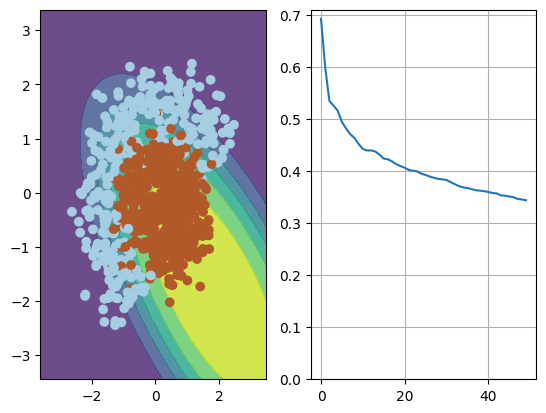

<Figure size 640x480 with 0 Axes>

In [47]:
# --- Adagrad ---
w = np.array([0,0,0,0,0,1], dtype=float)   # make w float

alpha = 0.1        # try 0.01, 0.05, 0.1
eps = 1e-8
G = np.zeros_like(w, dtype=float)   # accumulated squared gradients

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    grad = compute_grad(X[ind,:], y[ind], w)

    # Adagrad update
    G += grad ** 2
    w = w - alpha * grad / (np.sqrt(G) + eps)

visualize(X, y, w, loss)
plt.clf()


### Adam

Adam combines the benefits of Momentum and RMSProp.  
It maintains both a moving average of the gradients (momentum) and a moving average of squared gradients (RMS).  

The update rules are:

$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$

$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$

Bias correction:

$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}$

Final parameter update:

$w_{t+1} = w_t - \frac{\alpha \, \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$

where:  
- $g_t$ = gradient at time step $t$,  
- $m_t$ = exponentially decaying average of past gradients (momentum),  
- $v_t$ = exponentially decaying average of past squared gradients,  
- $\alpha$ = learning rate,  
- $\beta_1, \beta_2$ = decay rates (commonly $0.9, 0.999$),  
- $\epsilon$ = small constant for numerical stability.

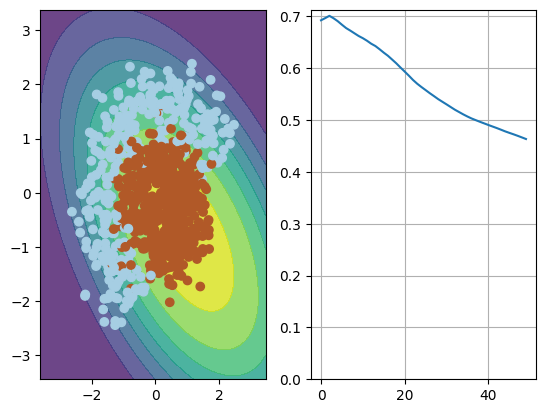

<Figure size 640x480 with 0 Axes>

In [46]:
# --- Adam ---
w = np.array([0,0,0,0,0,1])

alpha = 0.01        # learning rate (commonly 0.001–0.01)
beta1, beta2 = 0.9, 0.999
eps = 1e-8
m = np.zeros_like(w)   # momentum
v = np.zeros_like(w)   # rms
t = 0

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    grad = compute_grad(X[ind,:], y[ind], w)

    # Adam update
    t += 1
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)

    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)

    w = w - alpha * m_hat / (np.sqrt(v_hat) + eps)

visualize(X, y, w, loss)
plt.clf()
